In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from dotenv import load_dotenv
import hmac
import base64
import json
import time
import os
import requests
import backtesting as bt
import pandas_ta as ta
from backtesting import Backtest, Strategy
from joblib import load, dump

In [8]:
import scipy
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [9]:
load_dotenv()
api_key = os.environ.get('api_key')
api_secret = os.environ.get('api_secret')
api_passphrase = os.environ.get('api_passphrase')
api_url = "https://api.bitget.com"

In [10]:
def parse_params_to_str(params):
    url = '?'
    for key, value in params.items():
        url = url + str(key) + '=' + str(value) + '&'

    return url[0:-1]

def get_signature(message):
    mac = hmac.new(bytes(api_secret, encoding='utf8'), bytes(message, encoding='utf-8'), digestmod='sha256')
    d = mac.digest()
    return base64.b64encode(d)

def bitget_request(request_path, body, query, method):
    std_time = time.time() * 1000
    new_time = int(std_time)
    if str(body) == '{}' or str(body) == 'None':
        converted_body = ''
    else:
        converted_body = json.dumps(body)

    message = str(new_time) + method + request_path + parse_params_to_str(query) + converted_body

    headers = {"ACCESS-KEY": api_key,
               "ACCESS-SIGN": get_signature(message),
               "ACCESS-TIMESTAMP": str(new_time),
               "ACCESS-PASSPHRASE": api_passphrase,
               "Content-Type": "application/json",
               "Locale": "en-PH"
               }
    
    if method == "GET":
        return requests.get((api_url + request_path), headers=headers, params=query)
    elif method == 'POST':
        return requests.post((api_url + request_path), headers=headers, data=converted_body)
    else:
        raise ValueError("Invalid HTTP method specified")

In [11]:
def extract_process_bitget_data(symbol, time_frame):
    request_path = '/api/v2/mix/market/candles'
    params = {'symbol': symbol,  'productType': 'USDT-FUTURES', 'granularity': time_frame, 'limit': 1000}

    candles = bitget_request(request_path, None, params, "GET").json().get('data')
    raw_crypto = pd.DataFrame(candles, dtype='float64')
    crypto = raw_crypto.iloc[:,0:-1]

    # set columns
    crypto.columns = ["openTime", "Open", "High", "Low", symbol+"_Close", "Volume"]

    # convert openTime to readable format
    pd.options.mode.copy_on_write = True
    crypto["openTime"] = pd.to_datetime(crypto["openTime"], unit='ms', utc=True)
    crypto["openTime"] = pd.to_datetime(crypto["openTime"].dt.tz_convert('Asia/Manila').dt.strftime('%Y-%m-%d %H:%M:%S'))
    crypto.set_index('openTime', inplace=True)

    # supertrend = ta.supertrend(high=crypto.High, low=crypto.Low, close=crypto[symbol+'_Close'], length=1, multiplier=1).fillna(0)

    # crypto = pd.concat([crypto, supertrend], axis=1)
    
    crypto = crypto.asfreq('h')
    return crypto[symbol+"_Close"]

In [12]:
data1= extract_process_bitget_data('SUIUSDT', '1H')
data2= extract_process_bitget_data('BTCUSDT', '1H')
data3 = extract_process_bitget_data('ETHUSDT', '1H')

data = pd.concat([data1, data2, data3], axis=1)

In [13]:
data.isna().sum()

SUIUSDT_Close    0
BTCUSDT_Close    0
ETHUSDT_Close    0
dtype: int64

In [14]:
data['ret_SUIUSDT_Close'] = data.SUIUSDT_Close.pct_change(1).mul(100)
data['ret_BTCUSDT_Close'] = data.BTCUSDT_Close.pct_change(1).mul(100)
data['ret_ETHUSDT_Close'] = data.ETHUSDT_Close.pct_change(1).mul(100)

In [15]:
data.tail()

,SUIUSDT_Close,BTCUSDT_Close,ETHUSDT_Close,ret_SUIUSDT_Close,ret_BTCUSDT_Close,ret_ETHUSDT_Close
openTime,,,,,,
2025-06-20 14:00:00,2.7877,104668.8,2519.85,-0.132550,0.109608,0.195632
2025-06-20 15:00:00,2.8492,105742.4,2548.40,2.206120,1.025712,1.133004
2025-06-20 16:00:00,2.8378,105904.7,2552.01,-0.400112,0.153486,0.141658
2025-06-20 17:00:00,2.8379,105898.4,2552.24,0.003524,-0.005949,0.009013
2025-06-20 18:00:00,2.8432,106035.0,2554.25,0.186758,0.128992,0.078754


In [16]:
size = int(len(data)*0.8)
df, df_test = data.iloc[:size], data.iloc[size:]

In [17]:
model_auto = auto_arima(data.ret_SUIUSDT_Close[1:], exogenous = data[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']], m=5, 
                                max_order=None, max_p=7, max_q=7, max_d=2, max_P=4, max_Q=4, max_D=2, max_iter=50, alpha=0.05,
                                n_jobs=1, trend='ct', ic='aic', out_of_sample_size=int(len(df)*.2), random_state=42)

In [18]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                  999
Model:             SARIMAX(1, 0, 0, 5)   Log Likelihood               -1390.084
Date:                 Fri, 20 Jun 2025   AIC                           2788.168
Time:                         18:27:30   BIC                           2807.795
Sample:                              0   HQIC                          2795.628
                                 - 999                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.057      0.068      0.946      -0.107       0.115
drift       -6.46e-05      0.000     -0.600      0.549      -0.000       0.000
ar.S.L5       -0.0460      0.030     -1.551      0.121      -0.104       0.012
sigma2         0.9441      0.026     36.517      0.000       0.893       0.995
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):               990.46
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## AR MODEL

In [19]:
model_ar = ARIMA(df.ret_SUIUSDT_Close[1:], order=(5,0,0))
results_ar = model_ar.fit()

In [28]:
start_date = '2024-11-12 11:00:00'
end_date = '2024-11-20 18:00:00'
df_pred = results_ar.predict(start=start_date, end=end_date)

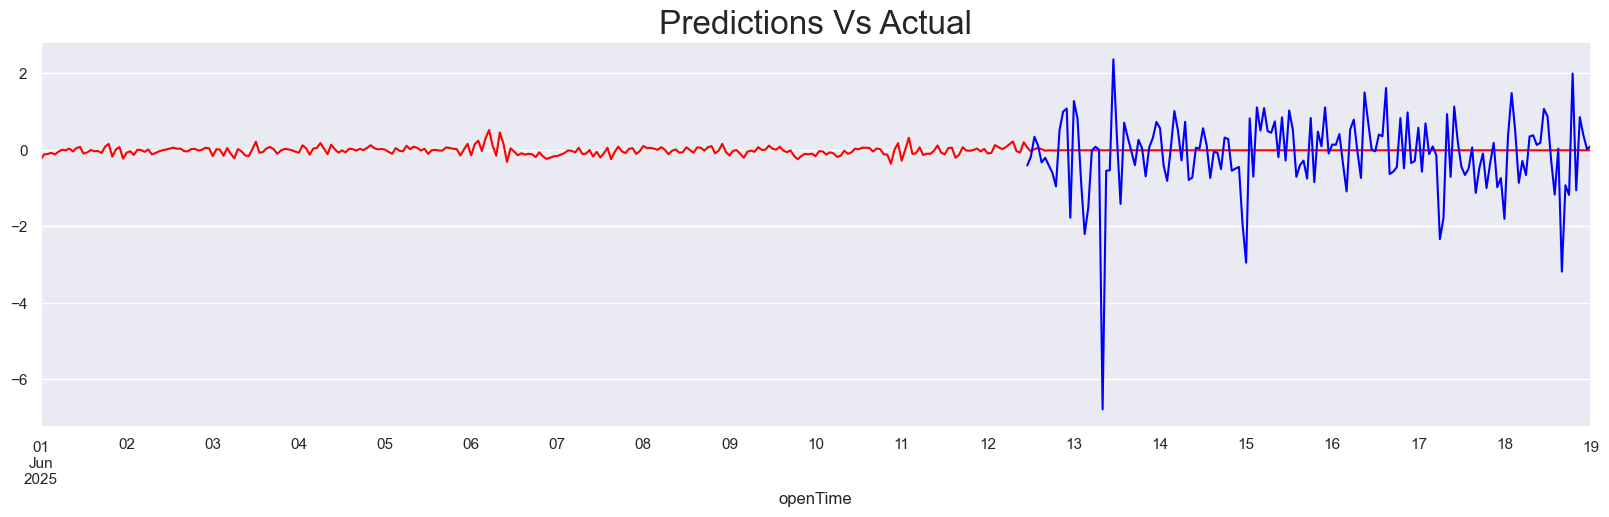

In [29]:
df_pred[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

## MA MODEL

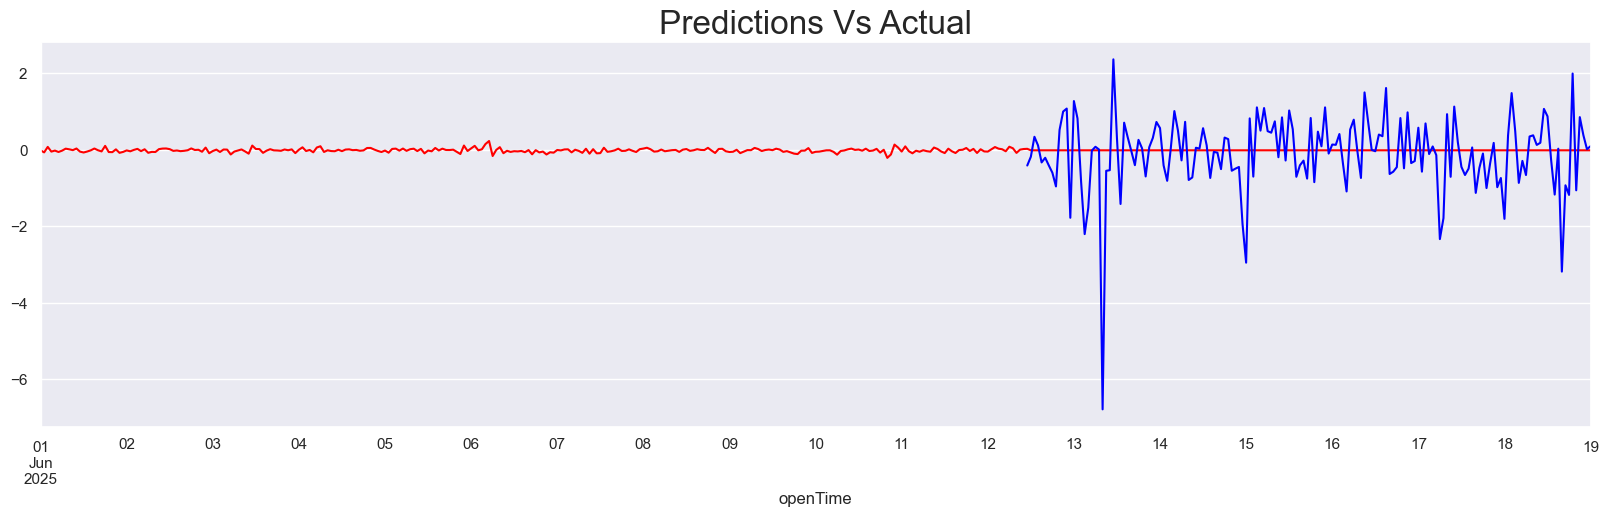

In [30]:
model_ar_ma = ARIMA(df.ret_SUIUSDT_Close[1:], order=(0,0,1))
results_ar_ma = model_ar_ma.fit()

# start_date = '2024-11-12 11:00:00'
# end_date = '2024-11-20 18:00:00'
df_pred_ma = results_ar_ma.predict(start=start_date, end=end_date)

df_pred_ma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

## ARMA MODEL

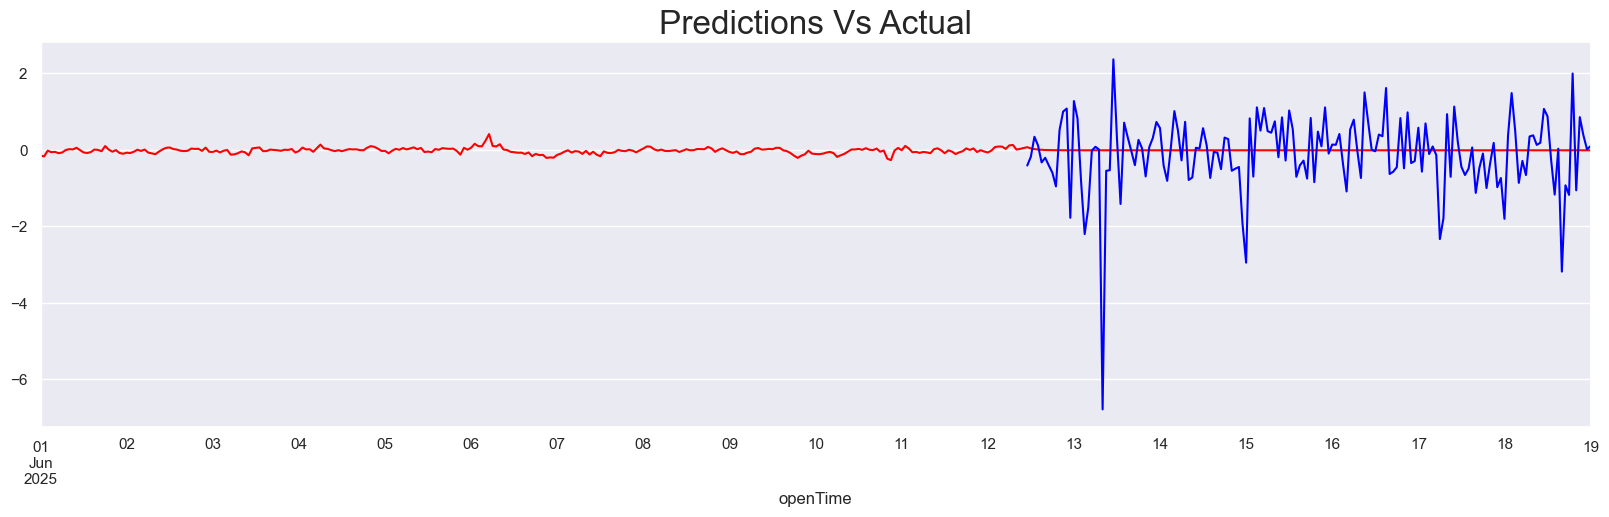

In [31]:
model_arma = ARIMA(df.ret_SUIUSDT_Close[1:], order=(1,0,1))
results_arma = model_arma.fit()

# start_date = '2024-11-12 11:00:00'
# end_date = '2024-11-20 18:00:00'
df_pred_arma = results_arma.predict(start=start_date, end=end_date)

df_pred_arma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

## ARMAX MODEL

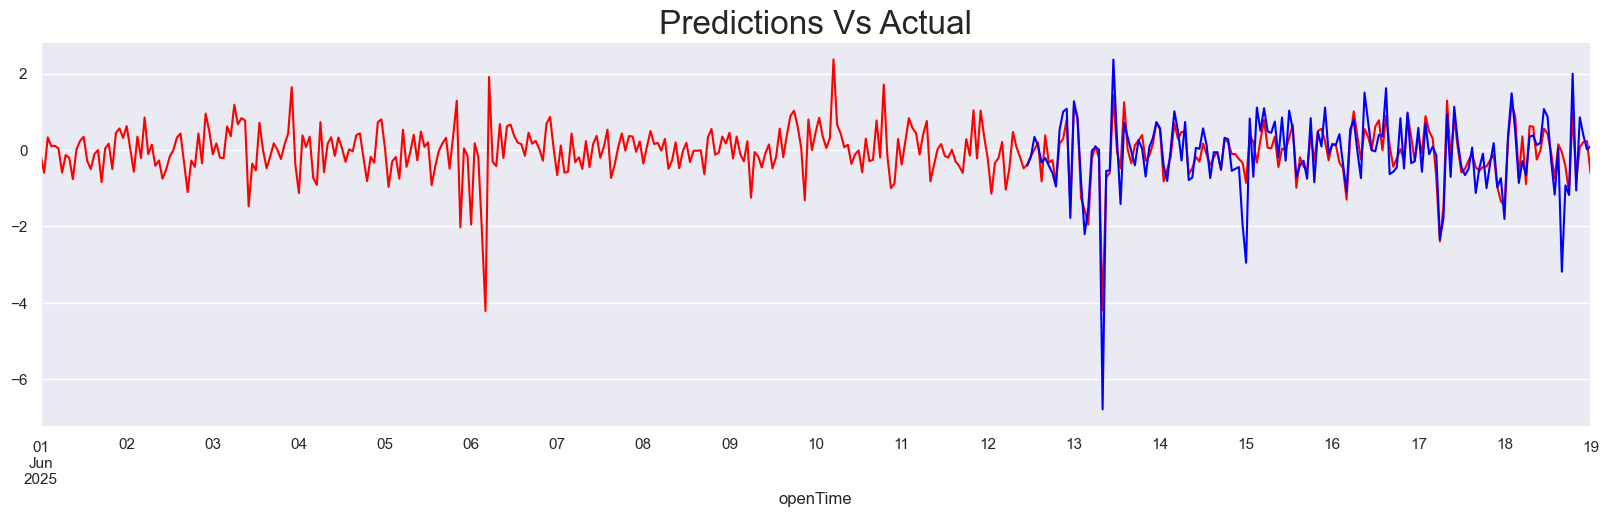

In [32]:
model_armax = ARIMA(df.ret_SUIUSDT_Close[1:], exog=df[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][1:], order=(1,0,1))
results_armax = model_armax.fit()

# start_date = '2024-11-12 11:00:00'
# end_date = '2024-11-20 18:00:00'
df_pred_armax = results_armax.predict(start=start_date, end=end_date,
                                    exog=df_test[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][start_date:end_date])

df_pred_armax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

In [33]:
# prediction_armax = df_pred_armax[start_date:end_date]
# result_armax = df_test.ret_SUIUSDT_Close[start_date:end_date]

In [34]:
# test = pd.concat([prediction_armax, result_armax], axis=1)
# test['prod'] = test.predicted_mean * test.ret_SUIUSDT_Close
# test[test['prod'] > 0].shape[0] / test.shape[0] * 100

## SARIMA

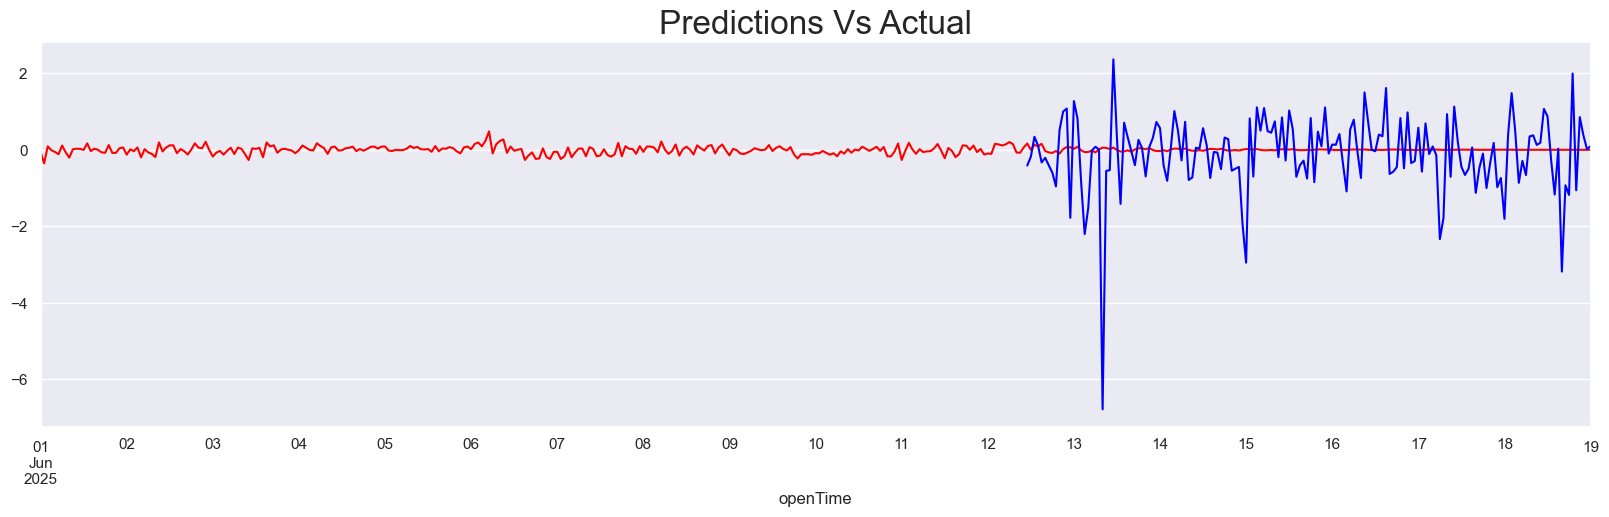

In [35]:
model_sarma = SARIMAX(df.ret_SUIUSDT_Close[1:], order=(1,0,1), seasonal_order=(3,0,2,5))
results_sarma = model_sarma.fit()

# start_date = '2024-11-12 11:00:00'
# end_date = '2024-11-20 18:00:00'
df_pred_sarma = results_sarma.predict(start=start_date, end=end_date)

df_pred_sarma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

## SARIMAX

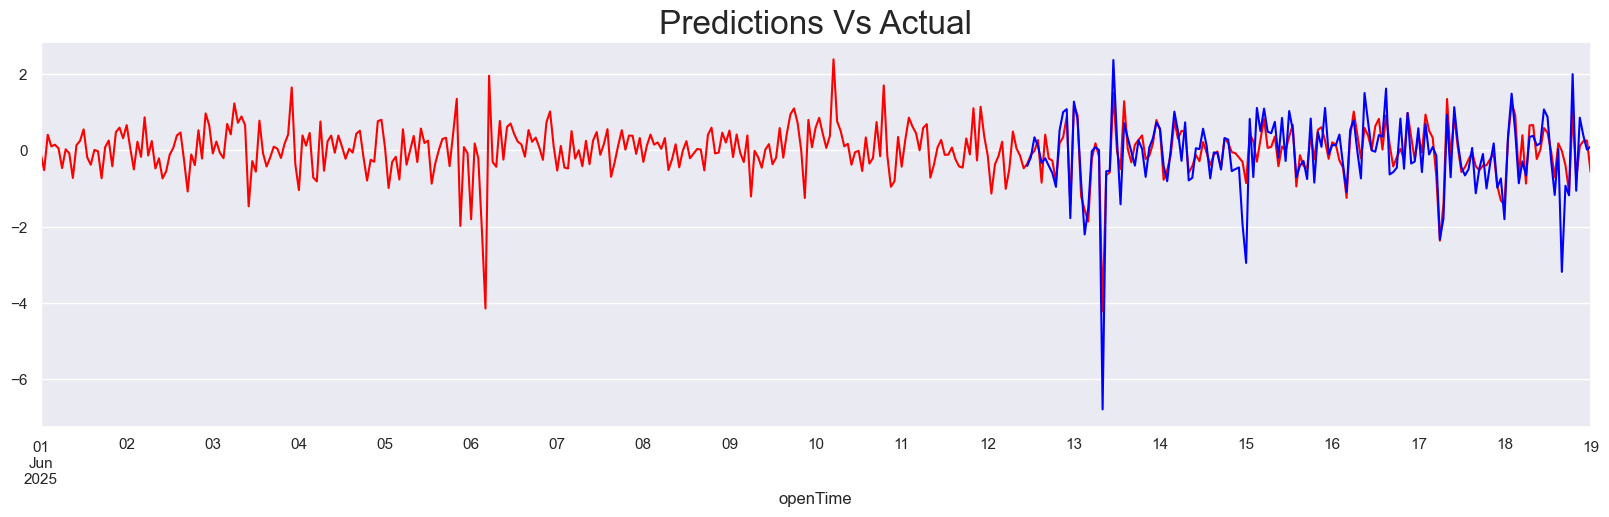

In [36]:
model_sarimax = SARIMAX(df.ret_SUIUSDT_Close[1:], exog=df[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][1:],
                          order=(1,0,1), seasonal_order=(3,0,2,5))
results_sarimax = model_sarimax.fit()

# start_date = '2024-11-12 11:00:00'
# end_date = '2024-11-20 18:00:00'
df_pred_sarimax = results_sarimax.predict(start=start_date, end=end_date,
                                        exog=df_test[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][start_date:end_date])

df_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

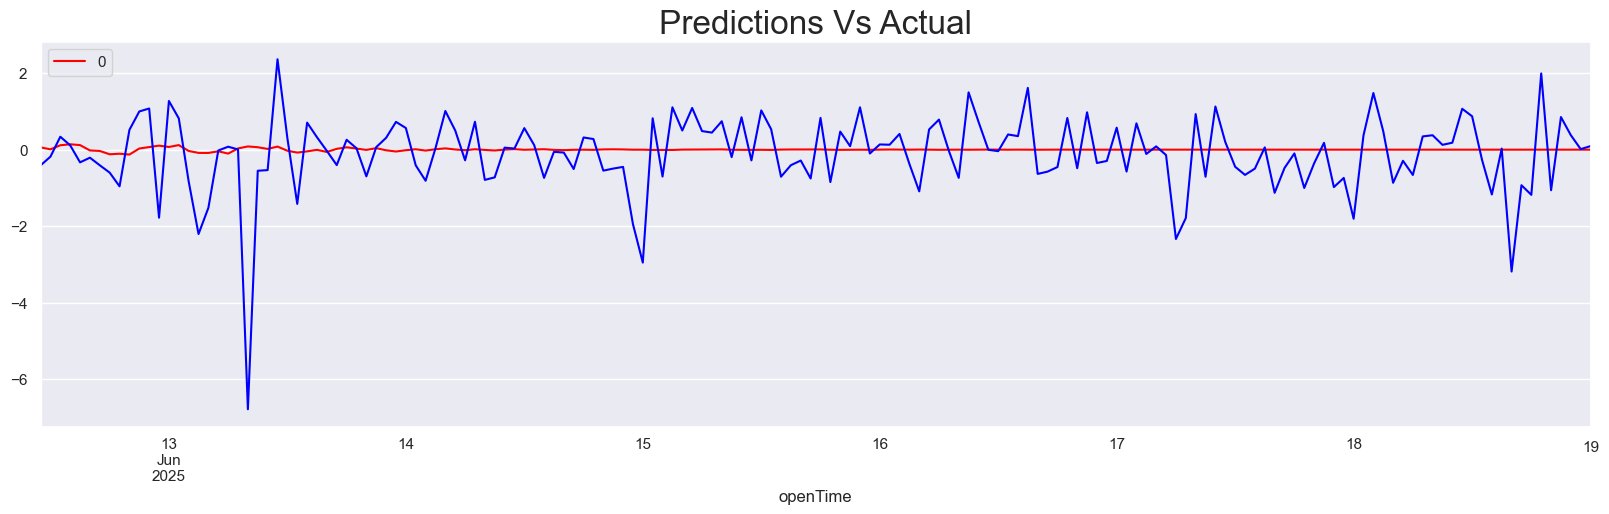

In [37]:
model_auto = auto_arima(df.ret_SUIUSDT_Close[1:], exogenous=df[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][1:],
                               m=5, max_p=5, max_d=2, max_q=5, max_P=5, max_Q=5, max_D=4)

# start_date = '2024-11-12 11:00:00'
# end_date = '2024-11-20 18:00:00'
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date]), 
                            exogenous=df_test[['ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][start_date:end_date]),
                            index=df_test[start_date:end_date].index)

df_auto_pred.plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Predictions Vs Actual', size=24)
plt.show()

## MULTIVARIATE REGRESSION MODEL

In [38]:
from statsmodels.tsa.api import VAR

In [39]:
df_ret = df[['ret_SUIUSDT_Close', 'ret_BTCUSDT_Close', 'ret_ETHUSDT_Close']][1:]

In [40]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic='aic')

In [41]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Jun, 2025
Time:                     18:37:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.25994
Nobs:                     799.000    HQIC:                  -4.27076
Log likelihood:          -1689.33    FPE:                  0.0138770
AIC:                     -4.27752    Det(Omega_mle):       0.0138251
--------------------------------------------------------------------
Results for equation ret_SUIUSDT_Close
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.014139         0.034637           -0.408           0.683

Results for equation ret_BTCUSDT_Close
           coefficient       std. error           t-stat            prob
----------------------------------------

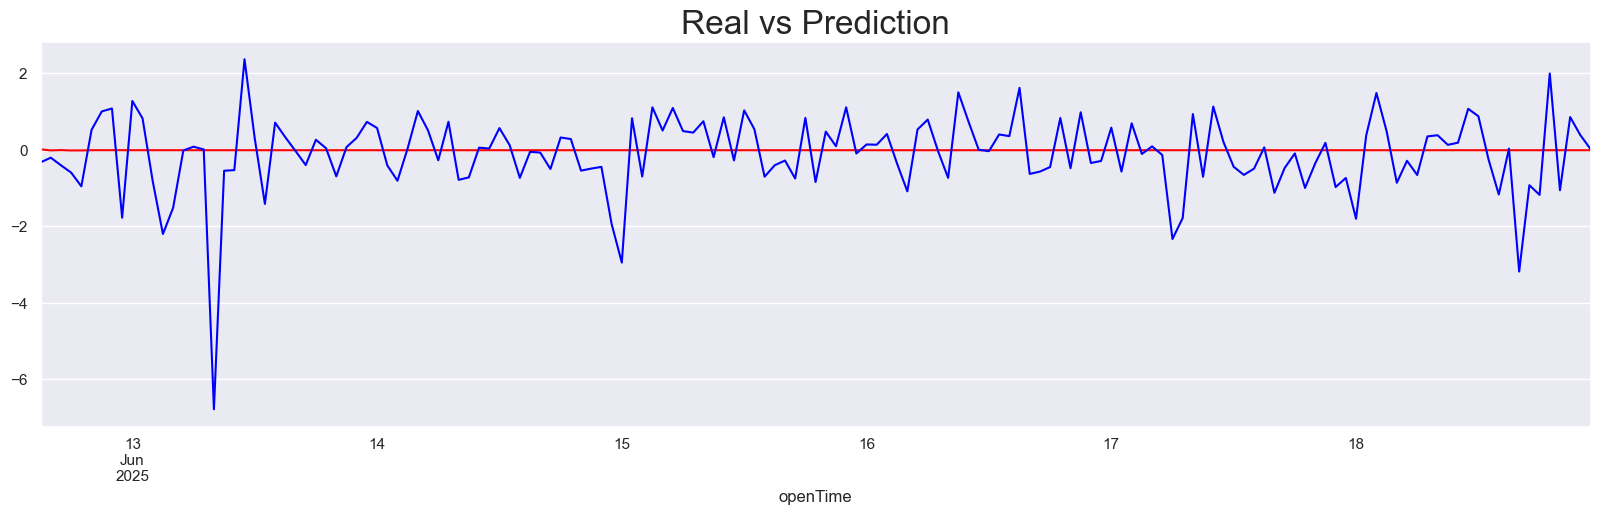

In [47]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data=var_pred_ret, index=df_test[start_date:end_date].index, columns=df_test[start_date:end_date].columns[3:])

df_ret_pred.ret_SUIUSDT_Close[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_SUIUSDT_Close[start_date:end_date].plot(color='blue')
plt.title('Real vs Prediction', size=24)
plt.show()